In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import ast
from matplotlib.ticker import FuncFormatter

In [2]:
hatches = {
    "nemo": "///",  # Triple diagonal lines
    "bottom_up": "+++",  # Triple plus signs
    "top_down": "xxx",  # Triple 'x' marks
    "mst": "ooo",  # Triple circles
    "chain": "///+++xxx"  # Combination of patterns
}


def format_func(value, tick_number):
    k_value = int(value) // 1000
    if k_value == 0:
        return f"{value:.0f}"
    elif k_value == 1:
        return f"{k_value}k"
    else:
        return f"{k_value:,}k"


def plot_bar_for_type(ax, df, type, val_col, ylabel, plot_order=None, title=True, show_text=True):
    df = df.groupby(['approach', 'type', 'node_id'])[val_col].max().reset_index()
    df = df.groupby(['approach', 'type'])[val_col].mean().reset_index()
    df = df[df['type'] == type]

    if plot_order is None:
        plot_order = df["approach"].tolist()

    for app in plot_order:
        val = df[df['approach'] == app][val_col].tolist()[0]  # Extract the single value
        ax.bar(app, val, color="grey", hatch=hatches[app])
        if show_text:
            ax.text(app, val, f"{val:.0f}", ha='center', va='bottom', fontsize=16)

    if show_text:
        # Calculate the maximum y-axis value
        max_y = ax.get_ylim()[1]
        # Set y-axis limit slightly higher to make space for labels
        ax.set_ylim(0, max_y * 1.4)

    # set title
    if type == "workers":
        type = "cluster heads"
    if title:
        ax.set_title(type)
    ax.set_ylabel(ylabel)

    # Apply the formatting function to the y-axis using FuncFormatter
    formatter = FuncFormatter(format_func)
    ax.yaxis.set_major_formatter(formatter)
    return ax


def convert_bytes_to_megabytes(df, columns):
    for col in columns:
        df[col] = df[col] / (1024 ** 2)  # convert from bytes to megabytes
    return df


def get_type(node_id, sinks, workers, sources):
    type = "invalid"
    node_id = int(node_id)
    if node_id in sinks:
        type = "sinks"
    elif node_id in workers:
        type = "workers"
    elif node_id in sources:
        type = "sources"
    return type


def parse_measurements(root_dir, directory_dict, file_name, type_dict, all_columns, val_columns, skip_head=1):
    rows = []

    for approach, directory in directory_dict.items():
        fname = root_dir + directory + "/" + file_name
        file = open(fname, 'r')
        lines = file.readlines()
        print("Reading lines for", fname)
        sinks, workers, sources = type_dict[approach]
        for line in lines:
            sline = line.split(",", 1)
            timestamp = sline[0]
            dictionary_str = sline[1]
            dictionary = ast.literal_eval(dictionary_str)
            for node_id, metrics_dict in dictionary.items():
                type = get_type(node_id, sinks, workers, sources)
                row = [float(timestamp), node_id, approach, type, float(metrics_dict["cpu_user"]),
                       float(metrics_dict["cpu_nice"]), float(metrics_dict["cpu_system"])]
                rows.append(row)

    df = pd.DataFrame(rows, columns=all_columns)
    df['node_id'] = df['node_id'].astype(int)
    # important pre-processing to remove the min values
    for col in val_columns:
        df[col] = df.groupby(['node_id', 'approach'])[col].transform(lambda x: x - x.min())
    # keep the same amount of measurements
    df['rank'] = df.groupby(['node_id', 'type', 'approach'])['time (s)'].rank().astype(int)
    measurements = df.groupby(['approach'])["rank"].max().min()
    df = df[(df["rank"] > skip_head) & (df["rank"] <= measurements)]
    return df

In [3]:
filename = "cpu_measurements.txt"

directory_dict_monitoring = {
    #"chain": "bottomUpWithMonitoringSourceChain",
    #"mst": "bottomUpWithMonitoringSourceMst",
    "top_down": "topDownWithMonitoringSourceThreeLevel",
    "bottom_up": "bottomUpWithMonitoringSourceThreeLevel",
    "nemo": "nemoPlacementWithMonitoringSourceThreeLevel"
}

directory_dict_stress_monitoring = {
    #"chain": "bottomUpWithMonitoringSourceChain_stressed",
    #"mst": "bottomUpWithMonitoringSourceMst_stressed",
    "top_down": "topDownWithMonitoringSourceThreeLevel_stressed",
    "bottom_up": "bottomUpWithMonitoringSourceThreeLevel_stressed",
    "nemo": "nemoPlacementWithMonitoringSourceThreeLevel_stressed"
}

directory_dict_debs = {
    "chain": "bottomUpDebsChain",
    "mst": "bottomUpDebsMst",
    "top_down": "topDownDebsThreeLevel",
    "bottom_up": "bottomUpDebsThreeLevel",
    "nemo": "nemoDebsThreeLevel"
}

directory_dict_stress_debs = {
    "chain": "bottomUpDebsChain_stress",
    "mst": "bottomUpDebsMst_stress",
    "top_down": "topDownDebsThreeLevel_stress",
    "bottom_up": "bottomUpDebsThreeLevel_stress",
    "nemo": "nemoDebsThreeLevel_stress"
}

core_cols = ["time (s)", "node_id", "approach", "type"]
columns = {
    "cpu": ["cpu_user", "cpu_nice", "cpu_system"],
    "net": ["R_BYTES", "R_PACKETS", "T_BYTES", "T_PACKETS"]
}

types = ["sinks", "sources", "workers"]
type_list = ([1], [2, 3], [4, 5, 6, 7, 8, 9, 10, 11])

type_dict = {
    "chain": type_list,
    "mst": type_list,
    "nemo": type_list,
    "bottom_up": type_list,
    "top_down": type_list
}

In [4]:
root_dir = "datasets/NES/221123/sliding_1min-50ms_100_20_3w_oc/"
directory_dict = directory_dict_debs

In [5]:
df_cpu_nostress = parse_measurements(root_dir, directory_dict, filename, type_dict, core_cols + columns["cpu"], columns["cpu"], skip_head=0)
df_cpu_nostress

Reading lines for datasets/NES/221123/sliding_1min-50ms_100_20_3w_oc/bottomUpDebsChain/cpu_measurements.txt
Reading lines for datasets/NES/221123/sliding_1min-50ms_100_20_3w_oc/bottomUpDebsMst/cpu_measurements.txt
Reading lines for datasets/NES/221123/sliding_1min-50ms_100_20_3w_oc/topDownDebsThreeLevel/cpu_measurements.txt
Reading lines for datasets/NES/221123/sliding_1min-50ms_100_20_3w_oc/bottomUpDebsThreeLevel/cpu_measurements.txt
Reading lines for datasets/NES/221123/sliding_1min-50ms_100_20_3w_oc/nemoDebsThreeLevel/cpu_measurements.txt


,time (s),node_id,approach,type,cpu_user,cpu_nice,cpu_system,rank
0,1.700671e+09,1,chain,sinks,0.0,0.0,0.0,1
1,1.700671e+09,2,chain,workers,0.0,0.0,0.0,1
2,1.700671e+09,3,chain,workers,0.0,0.0,0.0,1
3,1.700671e+09,4,chain,sources,0.0,0.0,0.0,1
4,1.700671e+09,5,chain,sources,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...
5585,1.700664e+09,6,nemo,sources,4736.0,0.0,354.0,105
5586,1.700664e+09,7,nemo,sources,4775.0,0.0,381.0,105
5587,1.700664e+09,8,nemo,sources,4728.0,0.0,389.0,105
5588,1.700664e+09,9,nemo,sources,4096.0,0.0,485.0,105


In [6]:
df_cpu_stress = parse_measurements(root_dir, directory_dict_stress_debs, filename, type_dict, core_cols + columns["cpu"],
                                   columns["cpu"], skip_head=0)
df_cpu_stress

Reading lines for datasets/NES/221123/sliding_1min-50ms_100_20_3w_oc/bottomUpDebsChain_stress/cpu_measurements.txt
Reading lines for datasets/NES/221123/sliding_1min-50ms_100_20_3w_oc/bottomUpDebsMst_stress/cpu_measurements.txt
Reading lines for datasets/NES/221123/sliding_1min-50ms_100_20_3w_oc/topDownDebsThreeLevel_stress/cpu_measurements.txt
Reading lines for datasets/NES/221123/sliding_1min-50ms_100_20_3w_oc/bottomUpDebsThreeLevel_stress/cpu_measurements.txt
Reading lines for datasets/NES/221123/sliding_1min-50ms_100_20_3w_oc/nemoDebsThreeLevel_stress/cpu_measurements.txt


,time (s),node_id,approach,type,cpu_user,cpu_nice,cpu_system,rank
0,1.700672e+09,1,chain,sinks,0.0,0.0,0.0,1
1,1.700672e+09,2,chain,workers,0.0,0.0,0.0,1
2,1.700672e+09,3,chain,workers,0.0,0.0,0.0,1
3,1.700672e+09,4,chain,sources,0.0,0.0,0.0,1
4,1.700672e+09,5,chain,sources,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...
5525,1.700665e+09,6,nemo,sources,93043.0,0.0,77166.0,105
5526,1.700665e+09,7,nemo,sources,93253.0,0.0,76976.0,105
5527,1.700665e+09,8,nemo,sources,93153.0,0.0,77082.0,105
5528,1.700665e+09,9,nemo,sources,93060.0,0.0,77149.0,105


## CPU Utilization

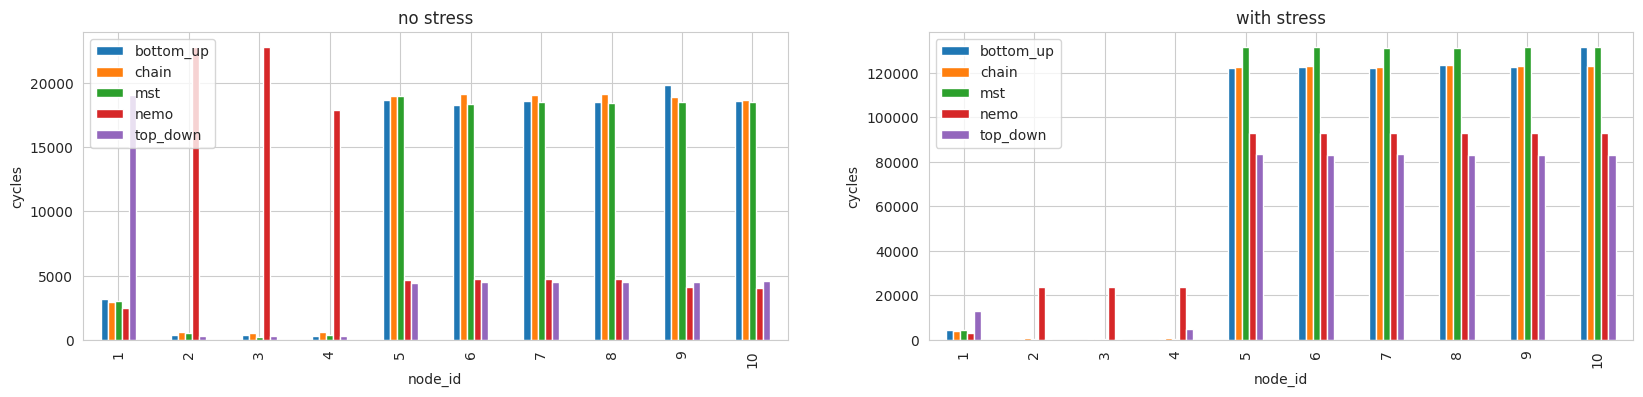

In [7]:
# Create a grouped bar plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
val_col = "cpu_user"

# no stress
grouped_df = df_cpu_nostress.groupby(['node_id', 'approach'])[val_col].max().reset_index()
pivot_df = grouped_df.pivot(index='node_id', columns='approach', values=val_col)
pivot_df.plot(kind='bar', ax=ax1)

# Add labels and title
ax1.set_xlabel('node_id')
ax1.set_ylabel('cycles')
ax1.set_title('no stress')
ax1.legend()

# stress
grouped_df = df_cpu_stress.groupby(['node_id', 'approach'])[val_col].max().reset_index()
pivot_df = grouped_df.pivot(index='node_id', columns='approach', values=val_col)
pivot_df.plot(kind='bar', ax=ax2)

# Add labels and title
ax2.set_xlabel('node_id')
ax2.set_ylabel('cycles')
ax2.set_title('with stress')
ax2.legend()

# Show the plot
plt.show()

Creating plot for type sinks
saving plots/NES/sinks_cpu_user.svg
Creating plot for type sources
saving plots/NES/sources_cpu_user.svg
Creating plot for type workers
saving plots/NES/workers_cpu_user.svg


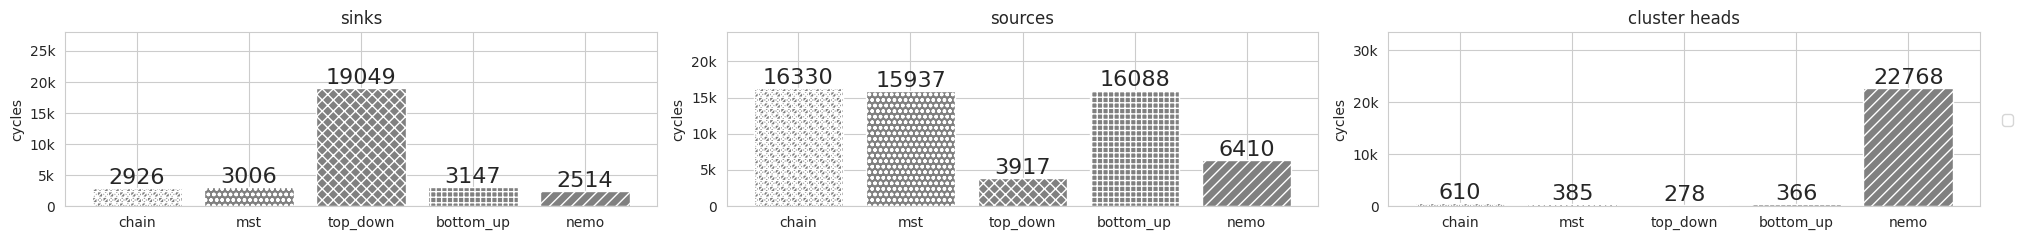

In [8]:
plot_col = "cpu_user"
df = df_cpu_nostress

for i, type in enumerate(types):
    # Create a new figure for each subplot
    print("Creating plot for type", type)
    fig, ax1 = plt.subplots(figsize=(8, 2))
    ax1 = plot_bar_for_type(ax1, df, type, plot_col, "cycles", plot_order=directory_dict.keys(), title=False)

    #ax.xaxis.label.set_size(20)
    ax1.yaxis.label.set_size(20)
    ax1.tick_params(axis='x', labelsize=20)

    fig.tight_layout()
    filename = os.path.join("plots/NES/", f"{type + '_' + plot_col}.svg")
    print("saving", filename)
    fig.savefig(filename)

    # Close the figure to free up memory
    plt.close(fig)

# Create the plot
fig, axs = plt.subplots(nrows=1, ncols=len(types), figsize=(20, 2.5))
for i, type in enumerate(types):
    axs[i] = plot_bar_for_type(axs[i], df, type, "cpu_user", "cycles", plot_order=directory_dict.keys())

# Create the legend outside the loop
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()

# Show the plot
plt.show()

## Produced Buffers

In [9]:
buf_dict = {}
for approach, directory in directory_dict.items():
    if approach.endswith("stress"):
        continue

    fname = root_dir + directory + "/number_of_buffers_query_1.txt"
    df = pd.read_csv(fname, names=["timestamp", "buffers"])
    buf_dict[approach] = df

buf_dict.keys()

dict_keys(['chain', 'mst', 'top_down', 'bottom_up', 'nemo'])

In [10]:
buf_dict["bottom_up"]

,timestamp,buffers
0,1.700665e+09,192
1,1.700665e+09,372
2,1.700665e+09,526
3,1.700665e+09,701
4,1.700665e+09,859
...,...,...
99,1.700666e+09,16499
100,1.700666e+09,16672
101,1.700666e+09,16840
102,1.700666e+09,17004


chain 17049
mst 17117
top_down 2220
bottom_up 17171
nemo 9806


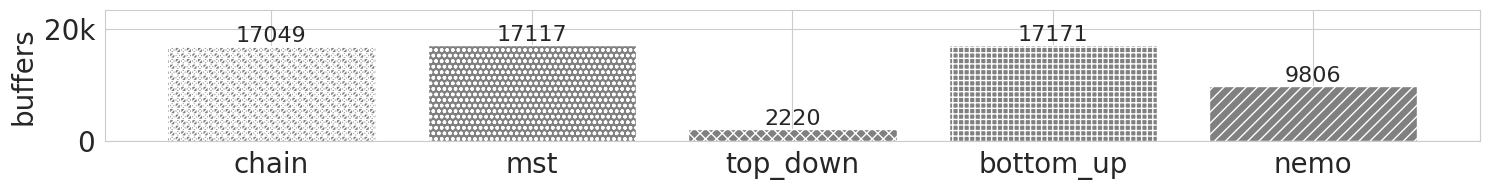

In [11]:
fig, ax1 = plt.subplots(figsize=(15, 2))
key_order = directory_dict.keys()

for k in key_order:
    df = buf_dict[k]
    val = df["buffers"].max()
    print(k, val)
    ax1.bar(k, val, hatch=hatches[k], color="grey")
    ax1.text(k, val, f"{val:.0f}", ha='center', va='bottom', fontsize=16)

# Calculate the maximum y-axis value
max_y = ax1.get_ylim()[1]
# Set y-axis limit slightly higher to make space for labels
ax1.set_ylim(0, max_y * 1.3)

plt.ylabel("buffers", fontsize=20)
plt.tick_params(axis='both', labelsize=20)

formatter = FuncFormatter(format_func)
ax1.yaxis.set_major_formatter(formatter)

fig.tight_layout()

plt.savefig("plots/NES/buffers" + ".svg")
plt.show()